In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    ONE_AND_HALF_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from src.sorted_spikes_simulation import (
    make_continuous_replay,
    make_fragmented_continuous_fragmented_replay,
    make_fragmented_hover_fragmented_replay,
    make_fragmented_replay,
    make_hover_continuous_hover_replay,
    make_hover_replay,
    make_simulated_run_data,
)

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

classifier = SortedSpikesClassifier(
    movement_var=movement_var,
    replay_speed=120,
    spike_model_penalty=0.5,
    place_bin_size=np.sqrt(movement_var),
    discrete_transition_diag=0.98,
)
classifier.fit(linear_distance, spikes)

SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                     'identity'],
                                                    ['uniform', 'uniform',
                                                     'uniform'],
                                                    ['random_walk', 'uniform',
                                                     'identity']],
                       discrete_transition_diag=0.98,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=10, movement_var=0.2775841643294236,
                       place_bin_size=0.5268625668325884, position_range=None,
                       replay_speed=120, spike_model_penalty=0.5)

In [4]:
from src.sorted_spikes_simulation import (
    make_hover_continuous_fragmented_replay,
    SAMPLING_FREQUENCY,
)
from src.parameters import STATE_ORDER, STATE_COLORS, TRANSITION_TO_CATEGORY

replay_time, test_spikes = make_hover_continuous_fragmented_replay()
replay_time *= SAMPLING_FREQUENCY
results = classifier.predict(test_spikes, time=replay_time).assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)
results

<xarray.Dataset>
Dimensions:            (position: 342, state: 3, time: 180)
Coordinates:
  * time               (time) float64 0.0 1.0 2.0 3.0 ... 177.0 178.0 179.0
  * position           (position) float64 0.2632 0.7895 1.316 ... 179.2 179.7
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
Data variables:
    likelihood         (time, state, position) float64 0.2629 0.2925 ... 0.00132
    causal_posterior   (time, state, position) float64 0.00331 ... 9.897e-07
    acausal_posterior  (time, state, position) float64 0.0003932 ... 9.897e-07

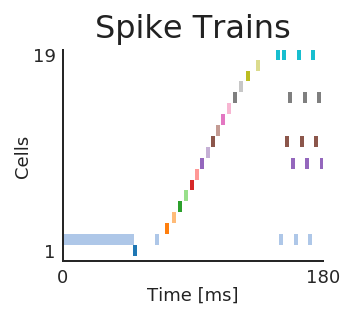

In [5]:
def plot_spikes(test_spikes, replay_time, ax=None, cmap=plt.get_cmap("tab20")):
    if ax is None:
        ax = plt.gca()
    spike_ind, neuron_ind = np.nonzero(test_spikes)

    c = [cmap.colors[ind] for ind in neuron_ind]
    ax.eventplot(
        replay_time[spike_ind][:, np.newaxis],
        lineoffsets=neuron_ind + 1,
        colors=c,
        linewidth=2,
    )
    ax.set_yticks((1, test_spikes.shape[1]))
    ax.set_ylabel("Cells")
    ax.set_ylim((0, test_spikes.shape[1] + 0.4))
    ax.set_xlabel("Time [ms]")
    ax.set_xlim((replay_time.min(), replay_time.max() + 1))
    ax.set_xticks((replay_time.min(), replay_time.max() + 1))
    ax.set_title("Spike Trains", fontsize=16)
    sns.despine()


fig, ax = plt.subplots(figsize=(TWO_COLUMN / 3, PAGE_HEIGHT / 5))
plot_spikes(test_spikes, replay_time, ax=ax)

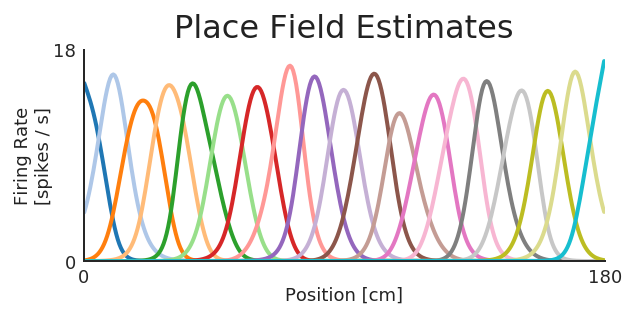

In [6]:
def plot_place_field_estimates(classifier, ax=None, cmap=plt.get_cmap("tab20")):
    if ax is None:
        ax = plt.gca()

    for place_field, color in zip(classifier.place_fields_.T, cmap.colors):
        ax.plot(
            classifier.place_bin_centers_, place_field * 1000, linewidth=2, color=color
        )

    ax.set_ylabel("Firing Rate\n[spikes / s]")
    ax.set_ylim([0, np.ceil(classifier.place_fields_.max() * 1000)])
    ax.set_yticks([0, np.ceil(classifier.place_fields_.max() * 1000)])

    ax.set_xlabel("Position [cm]")
    dist_lim = (classifier.place_bin_edges_.min(), classifier.place_bin_edges_.max())
    ax.set_xlim(dist_lim)
    ax.set_xticks(dist_lim)
    ax.set_title("Place Field Estimates", fontsize=16)

    sns.despine()


fig, ax = plt.subplots(figsize=(2 * TWO_COLUMN / 3, PAGE_HEIGHT / 5))
plot_place_field_estimates(classifier, ax=ax)

Text(0.5, 1, 'Probability of\nDynamic Changing')

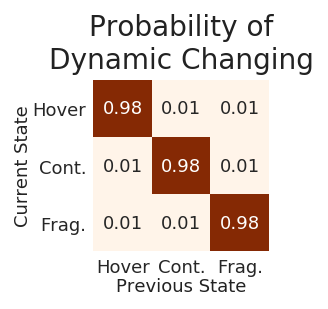

In [7]:
state_names = ["Hover", "Cont.", "Frag."]
fig, ax = plt.subplots(figsize=(ONE_COLUMN * 0.45, ONE_COLUMN * 0.45))
m = sns.heatmap(
    pd.DataFrame(
        classifier.discrete_state_transition_, index=state_names, columns=state_names
    ),
    annot=True,
    cmap="Oranges",
    ax=ax,
    cbar=False,
    annot_kws=dict(fontsize=9),
    cbar_kws=dict(label="Probability", ticks=[0, 1], orientation="horizontal"),
    vmin=0.0,
    vmax=1.0,
)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.xlabel("Previous State")
plt.ylabel("Current State")
plt.title("Probability of\nDynamic Changing", fontsize=14)

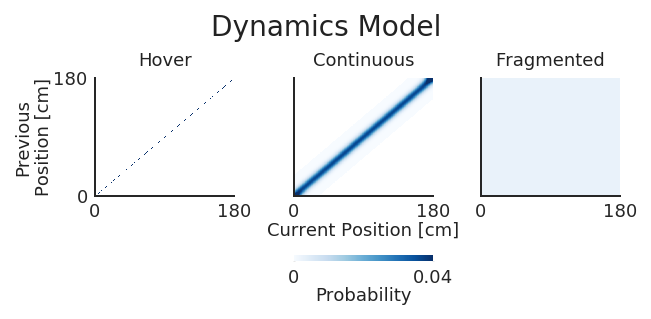

In [8]:
from src.parameters import TRANSITION_TO_CATEGORY


def plot_state_transition(classifier, vmax=0.04):
    fig, axes = plt.subplots(
        1,
        3,
        figsize=(ONE_AND_HALF_COLUMN * 0.8, ONE_AND_HALF_COLUMN / 3),
        sharex=True,
        sharey=True,
        constrained_layout=True,
    )

    x, y = np.meshgrid(classifier.place_bin_edges_, classifier.place_bin_edges_)
    state_names = [
        TRANSITION_TO_CATEGORY[transition]
        for transition in np.diag(classifier.continuous_transition_types)
    ]
    STATE_ORDER = ["Hover", "Continuous", "Fragmented"]

    for (ax, name) in zip(axes, STATE_ORDER):
        k = state_names.index(name)
        state_transition = classifier.continuous_state_transition_[k, k]
        state_transition[np.isclose(state_transition, 0.0)] = np.nan
        cmap = plt.cm.Blues
        cmap.set_bad(color="white", alpha=1.0)
        h = ax.pcolormesh(
            x, y, state_transition, cmap=cmap, vmin=0.0, vmax=vmax, rasterized=True,
        )
        ax.set_title(name, fontsize=9)

    cbar = fig.colorbar(
        h,
        label="Probability",
        aspect=10,
        ticks=[0, vmax],
        orientation="horizontal",
        ax=axes[1],
    )
    cbar.ax.set_xticklabels([0, vmax])  # vertically oriented colorbar
    cbar.outline.set_visible(False)
    dist_lim = (classifier.place_bin_edges_.min(), classifier.place_bin_edges_.max())
    axes[-1].set_xticks(dist_lim)
    axes[-1].set_yticks(dist_lim)
    axes[1].set_xlabel("Current Position [cm]")
    axes[0].set_ylabel("Previous\nPosition [cm]")
    plt.suptitle("Dynamics Model", y=1.12, fontsize=14)

    sns.despine()


plot_state_transition(classifier)

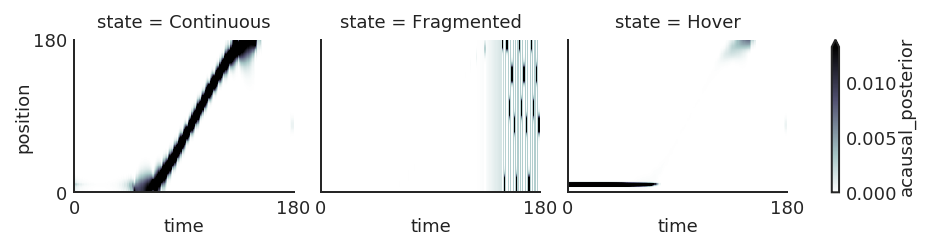

In [9]:
def plot_posteriors(results, linear_distance):
    results.acausal_posterior.plot(
        x="time",
        y="position",
        robust=True,
        vmin=0.0,
        rasterized=True,
        col="state",
        cmap="bone_r",
        figsize=(TWO_COLUMN, PAGE_HEIGHT / 5),
    )

    ylim = linear_distance.min(), linear_distance.max()
    plt.ylim(ylim)
    plt.yticks(ylim)

    xlim = results.time.min(), results.time.max() + 1
    plt.xlim(xlim)
    plt.xticks(xlim)
    sns.despine()


plot_posteriors(results, linear_distance)

(0.0, 1.0, 0.0, 1.0)

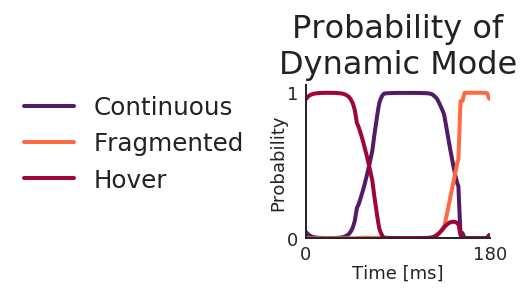

In [10]:
def plot_probabilities(results, ax=None):
    if ax is None:
        ax = plt.gca()
    probabilities = results.acausal_posterior.sum("position").values

    for probability, state in zip(probabilities.T, results.state.values):
        ax.plot(
            results.time,
            probability,
            linewidth=2,
            label=state,
            color=STATE_COLORS[state],
        )
    xlim = results.time.min(), results.time.max() + 1
    ax.set_xticks(xlim)
    ax.set_xlim(xlim)
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Probability")
    ax.set_yticks([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_title("Probability of\nDynamic Mode", fontsize=16)
    sns.despine()


fig, axes = plt.subplots(
    1,
    2,
    gridspec_kw={"width_ratios": [1, 5]},
    figsize=(TWO_COLUMN / 2, PAGE_HEIGHT / 5),
    constrained_layout=True,
)
plot_probabilities(results, ax=axes[1])
# ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.05))
h, l = axes[1].get_legend_handles_labels()
axes[0].legend(h, l, loc="upper center", borderaxespad=0.0, frameon=False)
axes[0].axis("off")

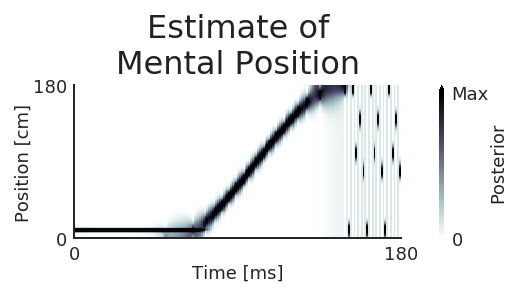

In [11]:
def plot_posterior(
    classifier,
    results,
    linear_distance,
    ax=None,
    cbar_orientation="vertical",
    cbar_aspect=50,
):
    if ax is None:
        ax = plt.gca()

    posterior = results.acausal_posterior.sum("state").values.T

    t, p = np.meshgrid(np.arange(results.time.size + 1), classifier.place_bin_edges_)

    h = ax.pcolormesh(
        t,
        p,
        posterior,
        vmin=0.0,
        vmax=np.percentile(posterior, 97.5),
        rasterized=True,
        cmap="bone_r",
    )
    cbar = plt.colorbar(
        h,
        label="Posterior",
        aspect=cbar_aspect,
        ticks=[0, np.percentile(posterior, 97.5)],
        ax=ax,
        orientation=cbar_orientation,
        extend="max",
    )
    cbar.ax.set_yticklabels(["0", "Max"])  # vertically oriented colorbar
    cbar.outline.set_visible(False)

    ax.set_title("Estimate of\nMental Position", fontsize=16)

    xlim = results.time.min(), results.time.max() + 1
    ax.set_xticks(xlim)
    ax.set_xlim(xlim)
    ax.set_xlabel("Time [ms]")

    ylim = linear_distance.min(), linear_distance.max()
    ax.set_yticks(ylim)
    ax.set_ylim(ylim)
    ax.set_ylabel("Position [cm]")
    sns.despine()


fig, ax = plt.subplots(
    constrained_layout=True, figsize=(TWO_COLUMN / 2, PAGE_HEIGHT / 5)
)
plot_posterior(classifier, results, linear_distance, ax=ax)

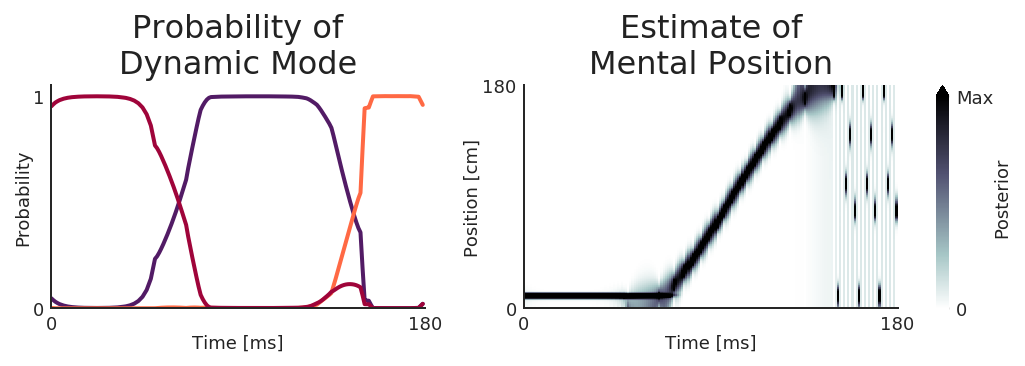

In [12]:
fig, axes = plt.subplots(
    1, 2, figsize=(TWO_COLUMN, PAGE_HEIGHT / 4), constrained_layout=True
)

plot_probabilities(results, ax=axes[0])
plot_posterior(
    classifier,
    results,
    linear_distance,
    ax=axes[1],
    cbar_orientation="vertical",
    cbar_aspect=50,
)
save_figure(os.path.join("Figure1", "figure1_prob_posterior"))

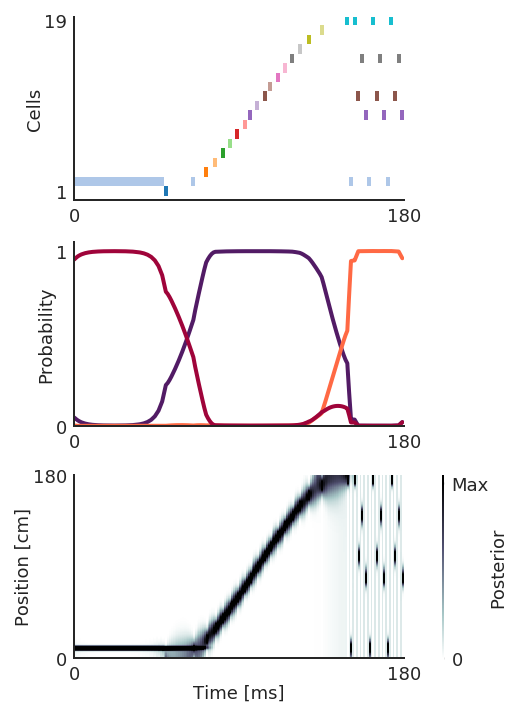

In [13]:
fig, axes = plt.subplots(
    3, 1, figsize=(ONE_COLUMN, PAGE_HEIGHT / 2), constrained_layout=True
)

plot_spikes(test_spikes, replay_time, ax=axes[0])
axes[0].set_title("")
axes[0].set_xlabel("")
plot_probabilities(results, ax=axes[1])
axes[1].set_title("")
axes[1].set_xlabel("")
plot_posterior(classifier, results, linear_distance, ax=axes[2])
axes[2].set_title("")

save_figure(os.path.join("Figure1", "figure1_spikes_prob_posterior"))

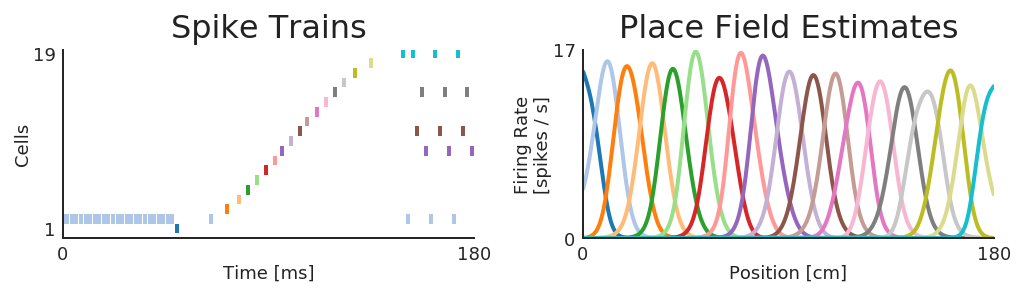

In [14]:
fig, axes = plt.subplots(
    1, 2, figsize=(TWO_COLUMN, PAGE_HEIGHT / 5), constrained_layout=True,
)
plot_spikes(test_spikes, replay_time, ax=axes[0])
plot_place_field_estimates(classifier, ax=axes[1])
save_figure(os.path.join("Figure1", "figure1_spikes_place_field"))

## Classification of Speeds

In [11]:
from src.sorted_spikes_simulation import make_constant_velocity_replay
from src.parameters import (
    ANIMALS,
    FIGURE_DIR,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
)

continuous_transition_types = [
    ["random_walk", "uniform", "identity"],  # noqa
    ["uniform", "uniform", "uniform"],  # noqa
    ["random_walk", "uniform", "identity"],
]  # noqa


classifier2 = SortedSpikesClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=0.9999,
    spike_model_penalty=spike_model_penalty,
    knot_spacing=knot_spacing,
).fit(linear_distance, spikes)

classifier2

SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                     'identity'],
                                                    ['uniform', 'uniform',
                                                     'uniform'],
                                                    ['random_walk', 'uniform',
                                                     'identity']],
                       discrete_transition_diag=0.9999,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=5, movement_var=6.0, place_bin_size=3.0,
                       position_range=None, replay_speed=1,
                       spike_model_penalty=0.5)

In [12]:
def get_constant_velocity_stats(classifier, actual_speed=1000):
    replay_time, test_spikes = make_constant_velocity_replay(replay_speed=actual_speed)

    results = classifier.predict(test_spikes, time=replay_time).assign_coords(
        state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
    )

    return results.acausal_posterior.sum("position").mean("time")

In [13]:
from dask.distributed import Client

client = Client(n_workers=16)
client

Client Scheduler: tcp://127.0.0.1:45805 Dashboard: http://127.0.0.1:34885/status,Cluster Workers: 16 Cores: 64 Memory: 1.62 TB


In [14]:
from tqdm.autonotebook import tqdm
import xarray as xr
import pandas as pd

# speeds = np.logspace(0, 4, num=400)
# speeds = np.insert(speeds, 0, 0)
# speeds = np.concatenate((np.arange(0, 101), np.arange(200, 10_100, 100)))
# speeds = np.concatenate(
#     (
#         np.array([1]),
#         np.arange(2, 10, 2),
#         np.arange(10, 50, 0.5),
#         np.arange(50, 100, 2),
#         np.arange(100, 1000, 100),
#         np.arange(1000, 5000, 20),
#         np.arange(5000, 10_100, 100),
#     )
# )
speeds = np.arange(0.5, 10_000.5, 0.5)

probabilities = xr.concat(
    [
        get_constant_velocity_stats(classifier2, actual_speed=speed)
        for speed in tqdm(speeds)
    ],
    dim=pd.Index(speeds, name="speed"),
)

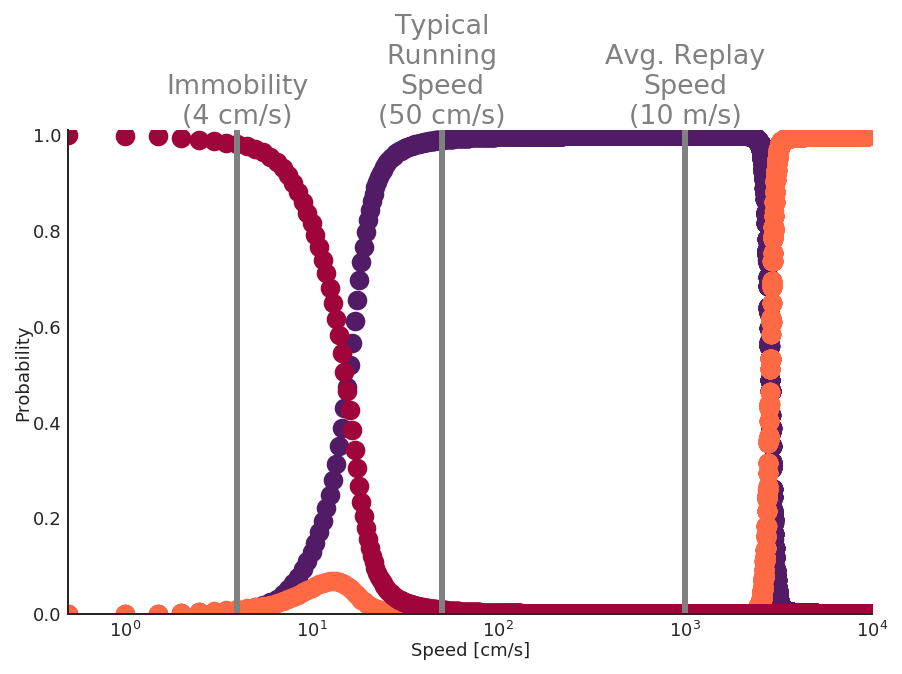

In [15]:
fig, ax = plt.subplots()

for state, prob in zip(probabilities.state.values, probabilities.values.T):
    ax.scatter(speeds, prob, linewidth=5, label=state, color=STATE_COLORS[state])

ax.axvline(4, color="grey", linewidth=3, linestyle="-")
ax.text(4, 1.01, "Immobility\n(4 cm/s)", va="bottom", ha="center", color="grey")

ax.axvline(50, color="grey", linewidth=3, linestyle="-")
ax.text(
    50,
    1.01,
    "Typical\nRunning\nSpeed\n(50 cm/s)",
    va="bottom",
    ha="center",
    color="grey",
)

ax.axvline(1000, color="grey", linewidth=3, linestyle="-")
ax.text(
    1000, 1.01, "Avg. Replay\nSpeed\n(10 m/s)", va="bottom", ha="center", color="grey"
)

ax.set_xlabel("Speed [cm/s]")

ax.set_ylabel("Probability")
ax.set_ylim((0, 1.01))

plt.xscale("log")
ax.set_xlim((speeds.min(), speeds.max()))
sns.despine()

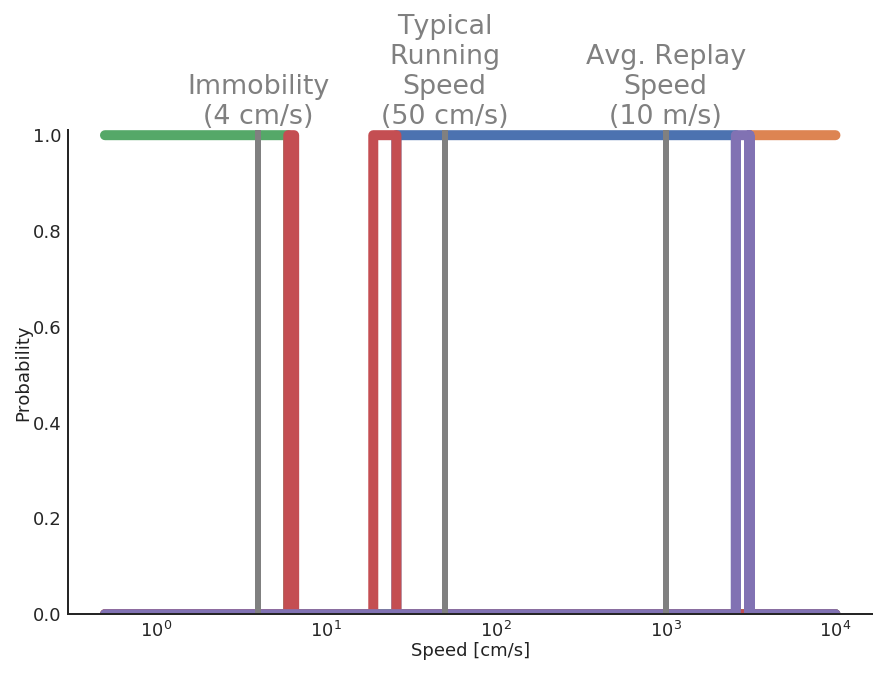

In [16]:
from src.analysis import get_is_classified
from src.parameters import PROBABILITY_THRESHOLD


p = xr.concat(
    (
        probabilities,
        probabilities.sel(state=["Hover", "Continuous"])
        .sum("state", skipna=False)
        .assign_coords(state="Hover-Continuous-Mix"),
        probabilities.sel(state=["Fragmented", "Continuous"])
        .sum("state", skipna=False)
        .assign_coords(state="Fragmented-Continuous-Mix"),
    ),
    dim="state",
)


is_classified = get_is_classified(p, 0.95)

is_classified.plot.step(
    x="speed", hue="state", xscale="log", linewidth=5, add_legend=False
)
plt.axvline(4, color="grey", linewidth=3, linestyle="-")
plt.text(4, 1.01, "Immobility\n(4 cm/s)", va="bottom", ha="center", color="grey")

plt.axvline(50, color="grey", linewidth=3, linestyle="-")
plt.text(
    50,
    1.01,
    "Typical\nRunning\nSpeed\n(50 cm/s)",
    va="bottom",
    ha="center",
    color="grey",
)

plt.axvline(1000, color="grey", linewidth=3, linestyle="-")
plt.text(
    1000, 1.01, "Avg. Replay\nSpeed\n(10 m/s)", va="bottom", ha="center", color="grey"
)

plt.ylabel("Probability")
plt.xlabel("Speed [cm/s]")
plt.ylim((0, 1.01))
sns.despine()

In [17]:
is_classified.sum("speed")

<xarray.DataArray 'is_classified' (state: 5)>
array([5.1330e+03, 1.3767e+04, 1.2000e+01, 1.5000e+01, 1.0480e+03])
Coordinates:
  * state    (state) object 'Continuous' ... 'Fragmented-Continuous-Mix'

In [18]:
is_classified.speed[is_classified.sel(state="Fragmented-Continuous-Mix").astype(bool)]

<xarray.DataArray 'speed' (speed: 1048)>
array([2593. , 2593.5, 2594. , ..., 3123.5, 3124. , 3124.5])
Coordinates:
  * speed    (speed) float64 2.593e+03 2.594e+03 ... 3.124e+03 3.124e+03
    state    <U25 'Fragmented-Continuous-Mix'

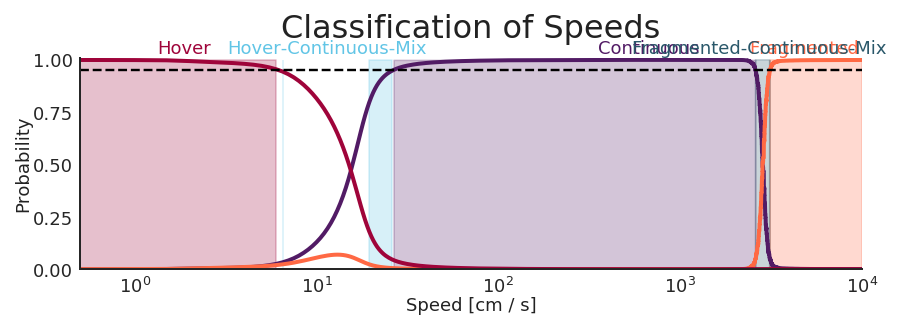

In [19]:
def plot_classification_of_speeds(probabilities, is_classified, ax=None):
    if ax is None:
        ax = plt.gca()

    for state, prob in zip(probabilities.state.values, probabilities.values.T):
        ax.plot(
            probabilities.speed,
            prob,
            linewidth=2,
            label=state,
            color=STATE_COLORS[state],
        )

    for state, is_class in zip(is_classified.state.values, is_classified.values.T):
        ax.fill_between(
            probabilities.speed,
            is_class,
            where=is_class.astype(bool),
            alpha=0.25,
            color=STATE_COLORS[state],
            interpolate=False,
        )
        speeds = probabilities.speed[is_class.astype(bool)]
        ax.text(
            speeds.min() + (speeds.max() - speeds.min()) / 4,
            1.01,
            state,
            va="bottom",
            ha="center",
            fontsize=9,
            color=STATE_COLORS[state],
        )

    ax.set_ylabel("Probability")
    ax.set_ylim((0, 1.01))

    ax.set_xlabel("Speed [cm / s]")
    ax.set_xscale("log")
    ax.set_xticks((1e0, 1e1, 1e2, 1e3, 1e4))
    ax.set_xlim((1e0, 1e4))
    ax.set_title("Classification of Speeds", fontsize=16, pad=10)

    ax.set_xlim((probabilities.speed.min(), probabilities.speed.max()))
    ax.axhline(0.95, color="black", linestyle="--")
    sns.despine()


fig, ax = plt.subplots(figsize=(TWO_COLUMN, PAGE_HEIGHT / 5))
plot_classification_of_speeds(probabilities, is_classified, ax=ax)

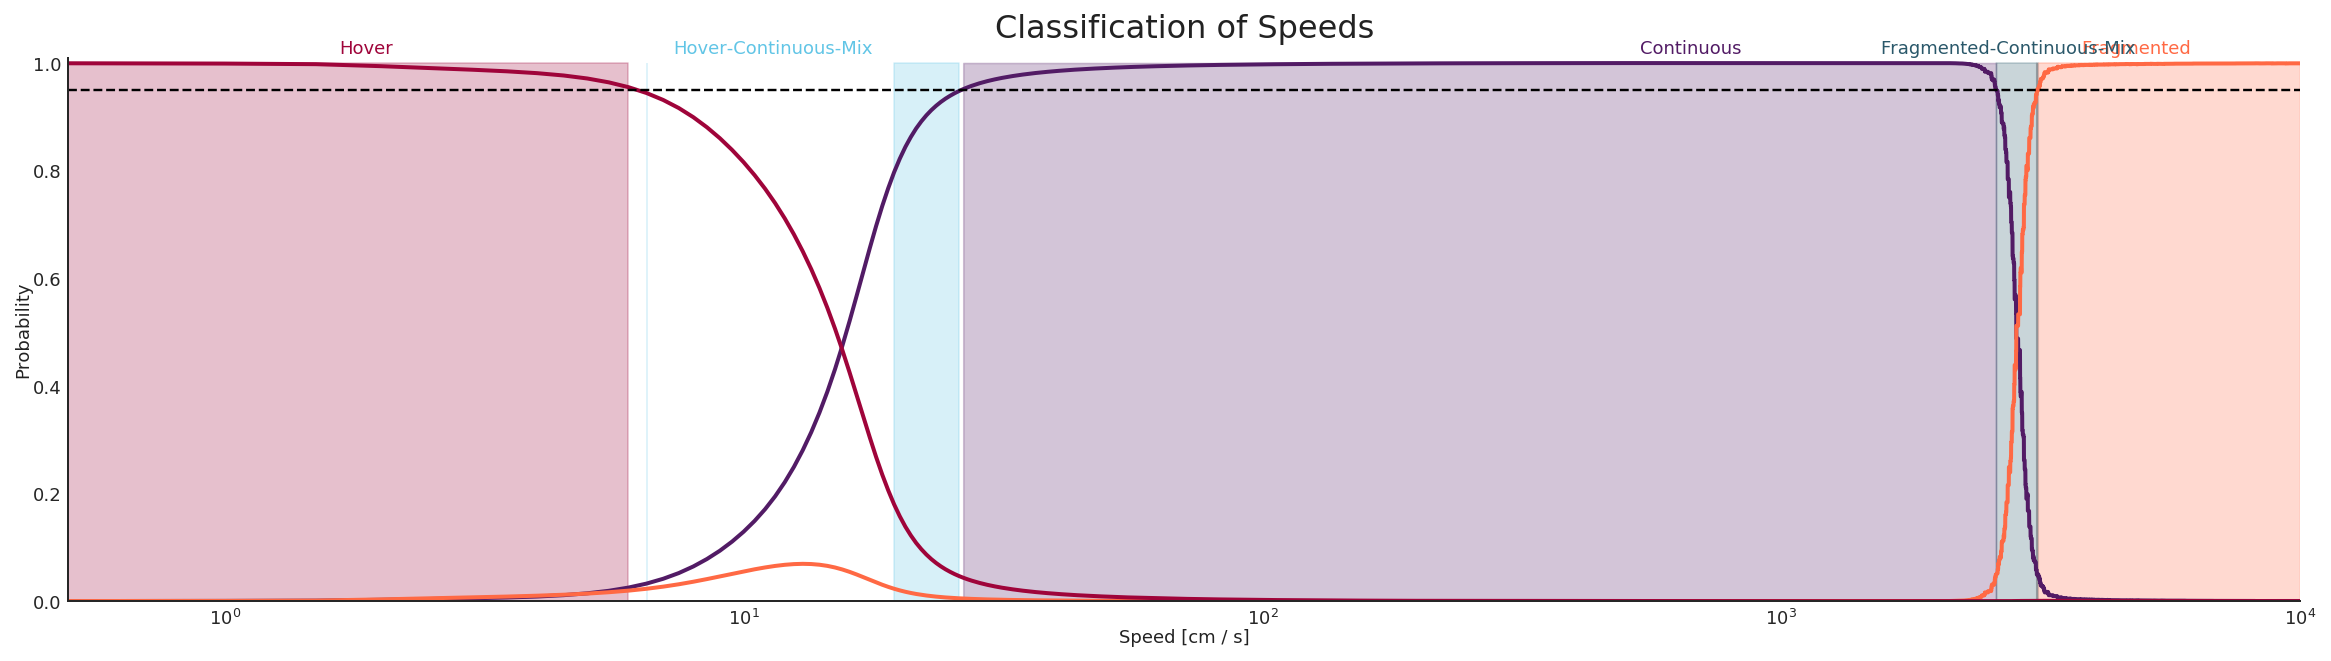

In [20]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_classification_of_speeds(probabilities, is_classified, ax=ax)

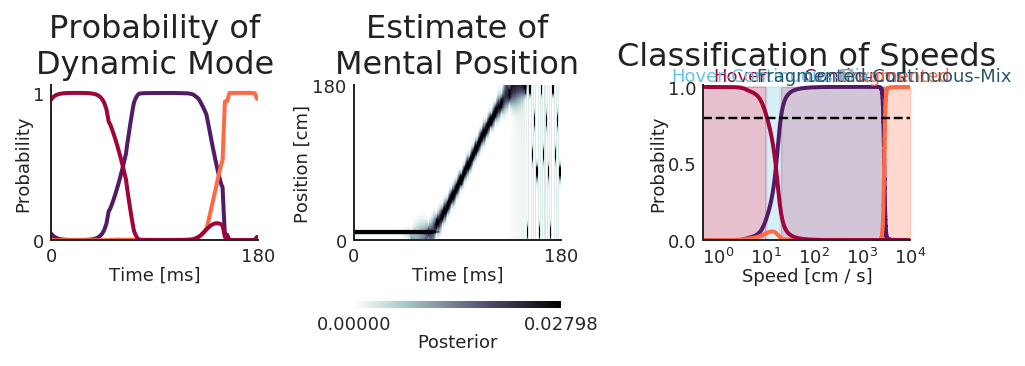

In [25]:
fig, axes = plt.subplots(
    1, 3, figsize=(TWO_COLUMN, PAGE_HEIGHT / 4), constrained_layout=True
)

plot_probabilities(results, ax=axes[0])
plot_posterior(
    classifier,
    results,
    linear_distance,
    ax=axes[1],
    cbar_orientation="Horizontal",
    cbar_aspect=10,
)
plot_classification_of_speeds(probabilities, is_classified, ax=axes[2])

Text(1000, 1.01, 'Avg. Replay\nSpeed\n(10 m/s)')

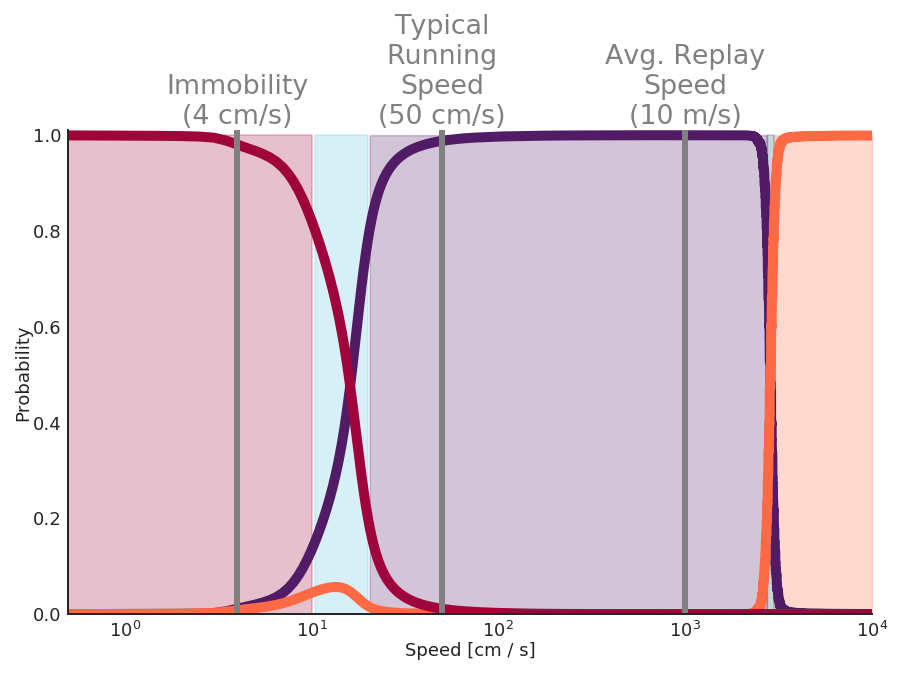

In [26]:
fig, ax = plt.subplots()

for state, prob in zip(probabilities.state.values, probabilities.values.T):
    ax.plot(speeds, prob, linewidth=5, label=state, color=STATE_COLORS[state])

for state, is_class in zip(is_classified.state.values, is_classified.values.T):
    ax.fill_between(
        speeds,
        is_class,
        where=is_class.astype(bool),
        alpha=0.25,
        color=STATE_COLORS[state],
    )

ax.set_xlabel("Speed [cm / s]")

ax.set_ylabel("Probability")
ax.set_ylim((0, 1.01))

plt.xscale("log")
ax.set_xlim((speeds.min(), speeds.max()))
sns.despine()

plt.axvline(4, color="grey", linewidth=3, linestyle="-")
plt.text(4, 1.01, "Immobility\n(4 cm/s)", va="bottom", ha="center", color="grey")

plt.axvline(50, color="grey", linewidth=3, linestyle="-")
plt.text(
    50,
    1.01,
    "Typical\nRunning\nSpeed\n(50 cm/s)",
    va="bottom",
    ha="center",
    color="grey",
)

plt.axvline(1000, color="grey", linewidth=3, linestyle="-")
plt.text(
    1000, 1.01, "Avg. Replay\nSpeed\n(10 m/s)", va="bottom", ha="center", color="grey"
)

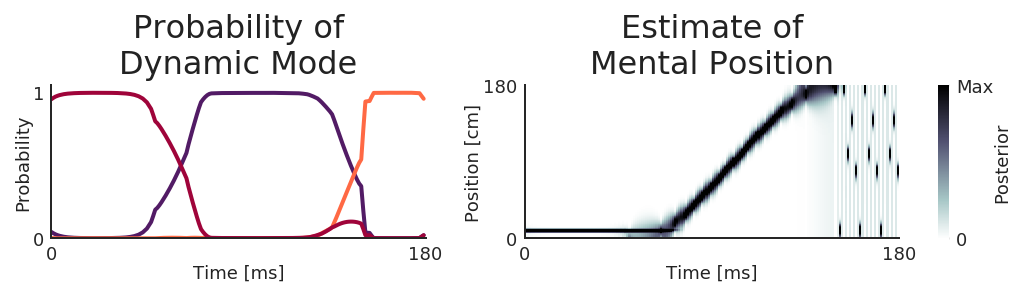

In [27]:
fig, axes = plt.subplots(
    1, 2, figsize=(TWO_COLUMN, PAGE_HEIGHT / 5), constrained_layout=True,
)
plot_probabilities(results, ax=axes[0])
plot_posterior(classifier, results, linear_distance, ax=axes[1])
save_figure(os.path.join("Figure1", "figure1_prob_posterior"))